# Sentiment Analysis – AML Group 14
This notebook demonstrates an advanced sentiment analysis pipeline with enhancements in feature extraction and classification. It incorporates character n-grams, reduced neutral class weight, and a custom probability threshold for improved performance. The methodology aims to balance precision and recall across sentiment classes.

## 1. Install / import

This section ensures the installation and import of all required libraries for data preprocessing, feature extraction, and model training. Libraries such as `scikit-learn`, `nltk`, and `transformers` are utilized for their robust NLP capabilities. The setup facilitates a seamless workflow for sentiment analysis tasks.

In [1]:
# Install required libraries
# !pip install -q scikit-learn pandas nltk joblib vaderSentiment transformers datasets torch matplotlib

# Import libraries
import pandas as pd, numpy as np, re, joblib, matplotlib.pyplot as plt, warnings
import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from scipy.sparse import hstack
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, pipeline
from datasets import Dataset
import torch
import numpy as np
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer

# Suppress warnings
warnings.filterwarnings('ignore')

# Download NLTK stopwords
nltk.download('stopwords', quiet=True)

# Define constants
STOP_WORDS = set(stopwords.words('english'))
VADER = SentimentIntensityAnalyzer()
NEG_TOKENS = {"not", "no", "never", "n't"}

/Users/mymac/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 2. Load data

The dataset is loaded into a Pandas DataFrame for efficient manipulation and analysis. It is assumed to contain columns for the text (`text`) and its corresponding sentiment label (`sentiment`). This step ensures the data is in the correct format for subsequent preprocessing and modeling.

In [2]:
df = pd.read_csv('dataset/train.csv')
assert {'text','sentiment'}.issubset(df.columns)

## 3. Pre‑processing with negation marking
Text preprocessing is a critical step in natural language processing (NLP). This function removes URLs, mentions, hashtags, and non-alphabetic characters, while also marking negations to capture contextual polarity shifts. The goal is to reduce noise and enhance the quality of features for sentiment classification.

In [3]:
def mark_negation(text):
    tokens = text.split()
    res, neg = [], False
    for w in tokens:
        lw = w.lower()
        if lw in NEG_TOKENS:
            neg = True
            res.append(lw)
            continue
        if re.fullmatch(r'[.!?]', lw):
            neg = False
        res.append(('NEG_' if neg else '') + lw)
    return ' '.join(res)

def preprocess(text):
    text = re.sub(r'http\S+|@[\w_]+|#[\w_]+|[^A-Za-z\s.!?]', ' ', str(text))
    text = text.lower()
    text = mark_negation(text)
    tokens = [w for w in text.split() if w not in STOP_WORDS]
    return ' '.join(tokens)

df['clean_text'] = df['text'].map(preprocess)
df['vader_comp'] = df['text'].map(lambda t: VADER.polarity_scores(t)['compound'])

## 4. Split
The dataset is split into training, validation, and test sets using stratified sampling to preserve class distribution. This ensures that the model is trained and evaluated on representative data subsets. The split facilitates robust model evaluation and hyperparameter tuning.

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df[['clean_text','vader_comp']], df['sentiment'], test_size=0.20,
    stratify=df['sentiment'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

## 5 Vectoriser & classifier

TF-IDF vectorization transforms text into numerical features, capturing both word and character n-grams. These features are combined with VADER sentiment scores to enrich the input representation. A Logistic Regression classifier is employed for its simplicity and effectiveness in text classification tasks.

In [5]:
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key): self.key = key
    def fit(self, X, y=None): return self
    def transform(self, X): return X[self.key]

class SparseVader(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X): return X[['vader_comp']].values

word_tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df=1, max_df=0.9, sublinear_tf=True)
char_tf = TfidfVectorizer(analyzer='char', ngram_range=(1,6), min_df=1, sublinear_tf=True)

features = FeatureUnion([
    ('word', make_pipeline(TextSelector('clean_text'), word_tf)),
    ('char', make_pipeline(TextSelector('clean_text'), char_tf)),
    ('vader', SparseVader())
])

clf = LogisticRegression(max_iter=1000, solver='liblinear',
                         class_weight={'negative':1.0,'positive':1.0,'neutral':0.8},
                         random_state=42)

pipe = Pipeline([('features', features), ('clf', clf)])

## 6. Grid search C
GridSearchCV is used to optimize the regularization parameter `C` for the Logistic Regression model. This process involves exhaustive search over specified parameter values using cross-validation. The goal is to identify the best hyperparameters that maximize the macro F1 score.

In [6]:
param_grid = {'clf__C':[0.5,1.0,1.5,2.0]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print('Best', grid.best_params_, grid.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best {'clf__C': 1.5} 0.7147152597352114


## 7. Validation with 0.55 threshold

The best model from GridSearchCV is evaluated on the validation set with a custom probability threshold. This threshold adjusts the classification decision boundary to improve the handling of the neutral class. Metrics such as precision, recall, and F1-score are computed for each class.

              precision    recall  f1-score   support

    negative       0.78      0.62      0.69      1401
     neutral       0.64      0.79      0.71      2004
    positive       0.80      0.71      0.76      1542

    accuracy                           0.72      4947
   macro avg       0.74      0.71      0.72      4947
weighted avg       0.73      0.72      0.72      4947



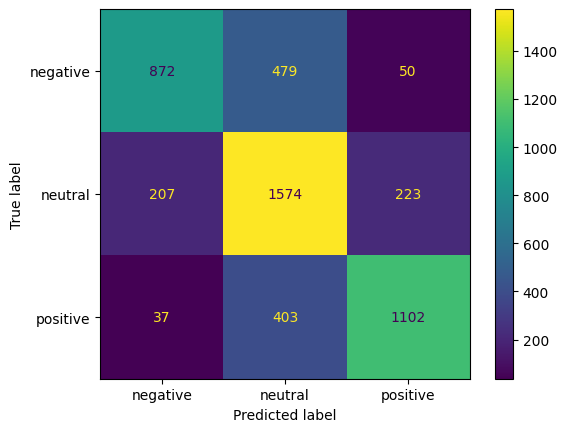

In [7]:
best = grid.best_estimator_
val_proba = best.predict_proba(X_val)
val_max = val_proba.max(1)
val_pred = np.where(val_max < 0.55, 'neutral', best.classes_[val_proba.argmax(1)])
print(classification_report(y_val, val_pred))
ConfusionMatrixDisplay(confusion_matrix(y_val, val_pred), display_labels=best.classes_).plot(); plt.show()

## 8. Retrain on train+val & test evaluation

The model is retrained on the combined training and validation sets to leverage all available labeled data. It is then evaluated on the test set to measure its final performance. The trained model is saved for future use and reproducibility.

              precision    recall  f1-score   support

    negative       0.79      0.61      0.69      1401
     neutral       0.65      0.80      0.71      2004
    positive       0.81      0.73      0.77      1542

    accuracy                           0.72      4947
   macro avg       0.75      0.71      0.72      4947
weighted avg       0.74      0.72      0.72      4947



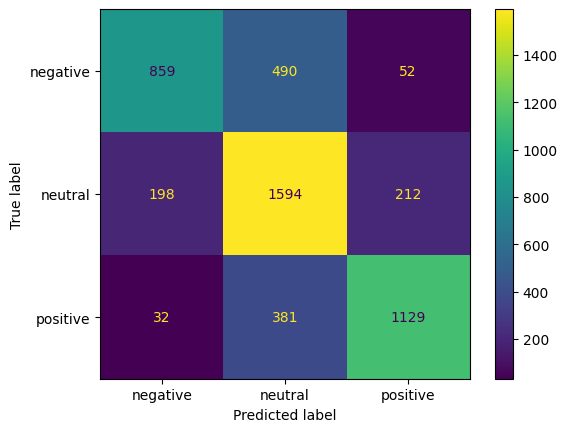

['./sentiment_model_v3.pkl']

In [8]:
best.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
test_proba = best.predict_proba(X_test)
test_max = test_proba.max(1)
y_test_pred = np.where(test_max < 0.55, 'neutral', best.classes_[test_proba.argmax(1)])
print(classification_report(y_test, y_test_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=best.classes_).plot(); plt.show()
joblib.dump(best, './sentiment_model_v3.pkl')

## 9. Save error cases
This step identifies and saves misclassified samples from the test set for error analysis. By examining these errors, insights can be gained into the model's weaknesses, such as handling ambiguous or noisy text. The results are saved in a CSV file for further inspection.

In [11]:
errors = pd.DataFrame({'text': X_test['clean_text'], 'true': y_test, 'pred': y_test_pred})
errors = errors[errors.true != errors.pred]
errors.to_csv('./results/sentiment_errors_v3.csv', index=False)
errors.head()

,text,true,pred
4033,aw sorry cat NEG_worries NEG_about NEG_the NEG...,neutral,negative
9167,help jen monster energy drink crashing.,negative,neutral
8596,picked boston legal season enjoying now. NEG_m...,positive,neutral
8043,good morning gents! ya today?,neutral,positive
4770,sooo tired headache self inflicted course! goo...,neutral,negative


## BONUS: detecting the relevant words

In [12]:
def explain_tweet(tweet):
    # Preprocess the tweet (using the already defined preprocess function)
    clean = preprocess(tweet)
    
    # Retrieve the fitted word-level TF-IDF vectorizer from the sentiment pipeline.
    word_vectorizer = best.named_steps['features'].transformer_list[0][1].named_steps['tfidfvectorizer']
    analyzer = word_vectorizer.build_analyzer()
    
    # Tokenize the tweet using the vectorizer's analyzer.
    tokens = analyzer(tweet)
    
    # Generate the TF-IDF vector for the tweet.
    vec = word_vectorizer.transform([tweet])
    
    # Get VADER compound score for constructing the expected input.
    vader_score = VADER.polarity_scores(tweet)['compound']
    tweet_df = pd.DataFrame({'clean_text': [tweet], 'vader_comp': [vader_score]})
    
    # Predict sentiment using the pre-trained pipeline.
    pred_label = best.predict(tweet_df)[0]
    
    # Get the logistic regression classifier and determine the index of the predicted label.
    clf = best.named_steps['clf']
    class_index = list(clf.classes_).index(pred_label)
    coef = clf.coef_[class_index]  # Coefficients for the predicted class
    
    # Get the feature names from the TF-IDF vectorizer.
    feature_names = word_vectorizer.get_feature_names_out()
    
    # Iterate over the non-zero TF-IDF features in the tweet and compute their contribution.
    vec = vec.tocoo()
    contributions = {}
    for idx, tfidf_val in zip(vec.col, vec.data):
        word = feature_names[idx]
        contributions[word] = tfidf_val * coef[idx]
        
    # Filter to take only words that push the prediction (i.e. positive contribution).
    relevant = {w: score for w, score in contributions.items() if score > 0}
    # Sort the words by their contribution score (largest first).
    sorted_relevant = sorted(relevant.items(), key=lambda x: x[1], reverse=True)
    
    # For demonstration, take the top 2 words as the most relevant ones.
    top_words = [word for word, score in sorted_relevant][:2]
    
    print("Tweet:", tweet)
    print("Predicted sentiment:", pred_label)
    print("Relevant words contributing to sentiment:", " ".join(top_words))
    
# Example:
tweet_example = 'I really like this song'
explain_tweet(tweet_example)

Tweet: I really like this song
Predicted sentiment: positive
Relevant words contributing to sentiment: song really


## 10. Ensemble (SVM + LogReg + VADER)
This section implements an ensemble model that combines predictions from SVM, Logistic Regression, and VADER sentiment scores. The final prediction is determined by majority voting. This approach aims to improve overall classification performance.

              precision    recall  f1-score   support

    negative       0.74      0.66      0.69      1401
     neutral       0.68      0.71      0.70      2004
    positive       0.76      0.80      0.78      1542

    accuracy                           0.72      4947
   macro avg       0.73      0.72      0.72      4947
weighted avg       0.72      0.72      0.72      4947

[[ 920  401   80]
 [ 278 1423  303]
 [  50  257 1235]]


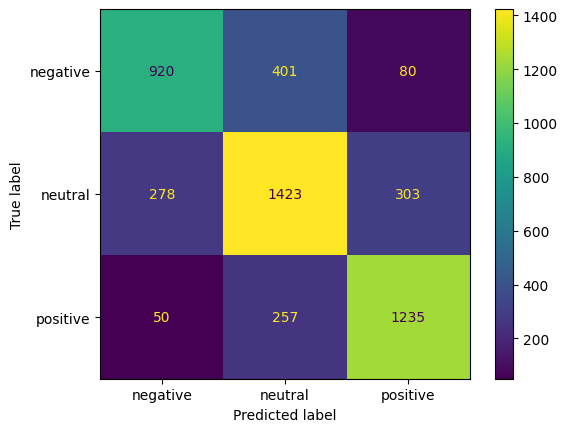

In [13]:
# Ensure the SVM pipeline is defined, and fit it if it hasn't been fitted already.
if 'svm' not in globals():
    from sklearn.svm import LinearSVC
    svm = Pipeline([
        ('features', features),
        ('clf', LinearSVC(class_weight='balanced', random_state=42))
    ])
svm.fit(X_train, y_train)

# Ensure we have a fitted logistic regression model.
# Here, we assign logreg to best (which was already fitted in previous cells).
logreg = best

# Define the missing vader_label function.
def vader_label(text):
    score = VADER.polarity_scores(text)['compound']
    if score >= 0.55:
        return 'positive'
    elif score <= -0.55:
        return 'negative'
    else:
        return 'neutral'

# ======== 3. Prediksi dan ensembel ========
def ensemble_predict(texts):
    """Majority-vote dari SVM, LogReg, VADER"""
    p_svm   = svm.predict(texts)
    p_log   = logreg.predict(texts)
    # Apply vader_label to the 'clean_text' column of the dataframe.
    p_vader = np.array([vader_label(t) for t in texts['clean_text']])

    preds = []
    for a, b, c in zip(p_svm, p_log, p_vader):
        votes = [a, b, c]
        # majority vote
        maj = max(set(votes), key=votes.count)
        if votes.count(maj) == 1:    # seri 1-1-1
            maj = b                 # fallback ke Logistic (lebih kalibrasi)
        preds.append(maj)
    return np.array(preds)

# ======== 4. Evaluasi ========
from sklearn.metrics import classification_report, confusion_matrix
y_pred = ensemble_predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=logreg.classes_).plot(); plt.show()

## BONUS: Jaccard Coefficient

In [14]:
def jaccard(str1, str2):
    a = set(str1.split())
    b = set(str2.split())
    union = a.union(b)
    return len(a.intersection(b)) / len(union) if union else 0

def predict_selected_words(tweet):
    # Preprocess the tweet as already defined
    clean = preprocess(tweet)
    
    # Retrieve the word-level TF-IDF vectorizer from the trained pipeline
    word_vectorizer = best.named_steps['features'].transformer_list[0][1].named_steps['tfidfvectorizer']
    
    # Tokenize and vectorize the raw tweet text (not the cleaned version)
    vec = word_vectorizer.transform([tweet])
    
    # Get the predicted sentiment label for the tweet
    pred_label = best.predict(pd.DataFrame({'clean_text': [tweet], 'vader_comp': [VADER.polarity_scores(tweet)['compound']]}))[0]
    clf = best.named_steps['clf']
    class_index = list(clf.classes_).index(pred_label)
    coef = clf.coef_[class_index]
    
    # Get feature names and compute contribution for each nonzero feature
    feature_names = word_vectorizer.get_feature_names_out()
    vec = vec.tocoo()
    contributions = {}
    for idx, tfidf_val in zip(vec.col, vec.data):
        contributions[feature_names[idx]] = tfidf_val * coef[idx]
    
    # Select words that contribute positively (if any)
    sorted_words = sorted(((w, score) for w, score in contributions.items() if score > 0), 
                          key=lambda x: x[1], reverse=True)
    # For demonstration, we take the top 2 words as the predicted selected words.
    top_words = [w for w, _ in sorted_words][:2]
    return " ".join(top_words)

# Apply the prediction and compute the Jaccard overlap.
# We use the full original dataframe "df" which contains the ground truth "selected_text".
df['predicted_selected'] = df['text'].apply(predict_selected_words)
df['jaccard'] = df.apply(lambda row: jaccard(row['predicted_selected'], row['selected_text']), axis=1)

print("Average Jaccard Coefficient:", df['jaccard'].mean())

Average Jaccard Coefficient: 0.18245612805218414


## 11. Fine-tune BERT-base-uncased
This section fine-tunes a pre-trained BERT model (`bert-base-uncased`) for sentiment analysis using the Hugging Face Transformers library. The model is trained on the processed dataset with class weights to handle imbalanced data. Fine-tuning allows the model to adapt to the specific sentiment classification task.

In [11]:
# Map labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
reverse_label_map = {v: k for k, v in label_map.items()}

# Gunakan kolom clean_text (sudah preprocessing)
hf_train = Dataset.from_pandas(
    pd.concat([X_train['clean_text'], y_train], axis=1)
      .rename(columns={'clean_text': 'text', 'sentiment': 'label'})
      .replace({'label': label_map})
)
hf_val = Dataset.from_pandas(
    pd.concat([X_val['clean_text'], y_val], axis=1)
      .rename(columns={'clean_text': 'text', 'sentiment': 'label'})
      .replace({'label': label_map})
)
hf_test = Dataset.from_pandas(
    pd.concat([X_test['clean_text'], y_test], axis=1)
      .rename(columns={'clean_text': 'text', 'sentiment': 'label'})
      .replace({'label': label_map})
)
# 

In [14]:
# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base')
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)
hf_train = hf_train.map(tokenize_function, batched=True)
hf_val = hf_val.map(tokenize_function, batched=True)
hf_test = hf_test.map(tokenize_function, batched=True)

hf_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
hf_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
# hf_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/14838 [00:00<?, ? examples/s]

Map:   0%|          | 0/4947 [00:00<?, ? examples/s]

Map:   0%|          | 0/4947 [00:00<?, ? examples/s]

In [15]:
#check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Model
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base', num_labels=3).to(device)

# Class weights
class_counts = y_train.map(label_map).value_counts().sort_index().values
weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# Custom Trainer untuk menggunakan weighted loss
from transformers import TrainerCallback
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    #evaluation_strategy="epoch",
    save_strategy="no",
    logging_dir='./logs',
    logging_steps=50,
    do_train=True,
    do_eval=True
)

# Custom metric dengan F1 macro
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        'accuracy': (preds == labels).mean(),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.071700
100,0.839700
150,0.699400
200,0.679200
250,0.689900
300,0.663500
350,0.664300
400,0.635100
450,0.663800
500,0.654800


TrainOutput(global_step=4640, training_loss=0.3964031755924225, metrics={'train_runtime': 423.414, 'train_samples_per_second': 175.219, 'train_steps_per_second': 10.959, 'total_flos': 4880096115310080.0, 'train_loss': 0.3964031755924225, 'epoch': 5.0})

In [17]:
# Evaluate on the test set
test_results = trainer.evaluate(hf_test)
print("Test Results:", test_results)

# Save the fine-tuned model
model.save_pretrained('./bert_sentiment_model')
tokenizer.save_pretrained('./bert_sentiment_model')

Test Results: {'eval_loss': 0.9076476097106934, 'eval_accuracy': 0.7638973115019203, 'eval_f1_macro': 0.7667653827268955, 'eval_runtime': 7.7825, 'eval_samples_per_second': 635.657, 'eval_steps_per_second': 19.916, 'epoch': 5.0}


('./bert_sentiment_model/tokenizer_config.json',
 './bert_sentiment_model/special_tokens_map.json',
 './bert_sentiment_model/vocab.json',
 './bert_sentiment_model/merges.txt',
 './bert_sentiment_model/added_tokens.json')

## 12. Predict with Fine-tuned BERT
The fine-tuned BERT model is used to predict sentiments on the test set. Predictions are compared with ground truth labels to evaluate the model's performance. Metrics such as accuracy and F1-score are computed to assess the effectiveness of the fine-tuned model.

Device set to use cuda:0


              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1401
           1       0.74      0.71      0.73      2004
           2       0.80      0.83      0.81      1542

    accuracy                           0.76      4947
   macro avg       0.76      0.77      0.77      4947
weighted avg       0.76      0.76      0.76      4947



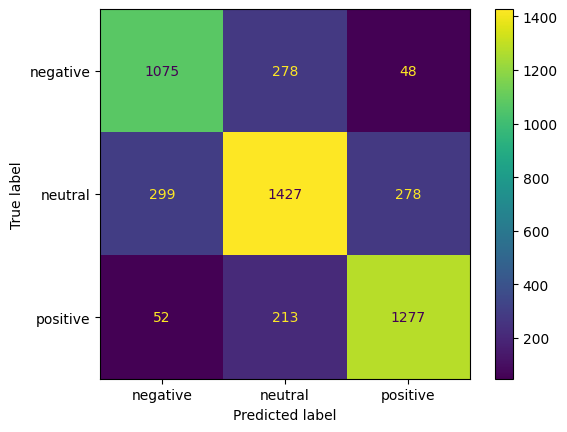

In [18]:
# Load the fine-tuned model
from transformers import pipeline
bert_pipeline = pipeline('text-classification', model='./bert_sentiment_model', tokenizer='./bert_sentiment_model', return_all_scores=True)

# Predict sentiments
bert_preds = [
	[k for k, v in label_map.items() if v == np.argmax([x['score'] for x in preds])][0]
	for preds in bert_pipeline(X_test['clean_text'].tolist())
]

# Evaluate predictions by mapping predicted labels to numeric values
bert_preds_mapped = [label_map[p] for p in bert_preds]
print(classification_report(y_test.map(label_map), bert_preds_mapped))
ConfusionMatrixDisplay(confusion_matrix(y_test.map(label_map), bert_preds_mapped), display_labels=list(label_map.keys())).plot(); plt.show()

In [19]:
# Predict on test set with threshold for 'neutral'
logits = trainer.predict(hf_test).predictions
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
preds = np.argmax(probs, axis=1)
max_scores = probs.max(axis=1)
final_preds = np.where(max_scores < 0.55, 1, preds)  # 1 = neutral

# Evaluate
print(classification_report(hf_test['label'], final_preds, target_names=label_map.keys()))
#ConfusionMatrixDisplay(confusion_matrix(hf_test.map(label_map), final_preds), display_labels=list(label_map.keys())).plot(); plt.show()

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76      1401
     neutral       0.74      0.72      0.73      2004
    positive       0.81      0.82      0.81      1542

    accuracy                           0.77      4947
   macro avg       0.77      0.77      0.77      4947
weighted avg       0.77      0.77      0.77      4947

